In [1]:
import numpy as np

In [2]:


A = np.array([10, 20, 30, 40, 50])
B = np.array([20, 50])
C = np.array([50, 20])
indices1 = np.where(np.isin(A, B))[0]
indices2 = np.where(np.isin(A, C))[0]

indices1, indices2

(array([1, 4]), array([1, 4]))

In [3]:


A = np.array([60, 10, 20, 30, 40, 50])
B = np.array([20, 50])
C = np.array([50, 20])

# Get the indices of B in A, in B's order
sort_idx = np.argsort(A)
indices_B = np.searchsorted(A, B)
indices_C = np.searchsorted(A, C)

sort_idx = np.argsort(A)
indices_B1 = sort_idx[np.searchsorted(A, B, sorter=sort_idx)]
indices_C1 = sort_idx[np.searchsorted(A, C, sorter=sort_idx)]



print(sort_idx)
print(indices_B)  # [1 4]
print(indices_C)  # [4 1]
print(indices_B1)  # [1 4]
print(indices_C1)  # [4 1]

[1 2 3 4 5 0]
[2 5]
[5 2]
[2 5]
[5 2]


In [4]:
import numpy as np

A = np.array([10, 20, 30, 40, 50])
B = np.array([20, 50])
C = np.array([50, 20])
indices1 = np.argwhere(A[:, None] == B)
indices2 = np.argwhere(A[:, None] == C)

indices1, indices2

(array([[1, 0],
        [4, 1]]),
 array([[1, 1],
        [4, 0]]))

In [5]:
A=np.arange(12*4*5).reshape(4,5,3,2,2)
print("A:", A.shape)

B = A.T.reshape(2,-1)
C = B.T.reshape(2,-1).T
print("B:", B.shape)
print("C:", C.shape)

D = np.sum(A*A, axis=4)
print("D:", D.shape)

A: (4, 5, 3, 2, 2)
B: (2, 120)
C: (120, 2)
D: (4, 5, 3, 2)


In [6]:
A = np.arange(2*3*4*5).reshape((5,4,3,2))
print(A.shape)
print(A.transpose(0, 1, 3, 2).shape)

print(A[0, 0])
print(A.transpose(0, 1, 3, 2)[0, 0])
print(A[0, 0]@A.transpose(0, 1, 3, 2)[0, 0])

(5, 4, 3, 2)
(5, 4, 2, 3)
[[0 1]
 [2 3]
 [4 5]]
[[0 2 4]
 [1 3 5]]
[[ 1  3  5]
 [ 3 13 23]
 [ 5 23 41]]


In [7]:
print(1%2, 2%2, 3%2, 4%2, 5%2)
print(1//2, 2//2, 3//2, 4//2, 5//2)

1 0 1 0 1
0 1 1 2 2


In [8]:
A = np.arange(2*3*4*5).reshape((5,4,3,2))
print(A.shape)
print(np.min(A, axis=(0,1)))

(5, 4, 3, 2)
[[0 1]
 [2 3]
 [4 5]]


In [9]:
mask = np.array([False, False, True, True, False, True, False, True, False, False])
true_indices = np.where(mask)[0]

print(true_indices)
print(np.diff(true_indices))
print(np.where(np.diff(true_indices) != 1)[0]+1)

groups = np.split(true_indices, np.where(np.diff(true_indices) != 1)[0] + 1)
# groups = [np.r_[group[0]-1, group, group[-1]+1] for group in groups]

extended_groups = []
for group in groups:
    start = max(group[0] - 1, 0)
    end = min(group[-1] + 1, mask.shape[0]-1)
    extended_groups.append(np.arange(start, end + 1))

print(true_indices)
print(groups)
print(extended_groups)

[2 3 5 7]
[1 2 2]
[2 3]
[2 3 5 7]
[array([2, 3]), array([5]), array([7])]
[array([1, 2, 3, 4]), array([4, 5, 6]), array([6, 7, 8])]


In [15]:
A=np.arange(3*2).reshape(3, 2)
B=-A
C=np.stack((A, B),1)

print(A.shape, B.shape, C.shape, sep="\n")
print(A, B, C, sep="\n")

(3, 2)
(3, 2)
(3, 2, 2)
[[0 1]
 [2 3]
 [4 5]]
[[ 0 -1]
 [-2 -3]
 [-4 -5]]
[[[ 0  1]
  [ 0 -1]]

 [[ 2  3]
  [-2 -3]]

 [[ 4  5]
  [-4 -5]]]


In [30]:
A=[
    [
        lambda n: np.array([x**2 for x in range(n)]),
        lambda n: np.array([x**3 for x in range(n)]),
    ],
    [
        lambda n: np.array([x**4 for x in range(n)]),
        lambda n: np.array([x**5 for x in range(n)]),
    ]
]

for i in range(2):
    for j in range(2):
        A[i][j] = lambda n: np.array([x**((i-1)*2+j) for x in range(1,n)])

for i in range(2):
    for j in range(2):
        print(A[i][j](5))

[1.         0.25       0.11111111 0.0625    ]
[1.         0.5        0.33333333 0.25      ]
[1 1 1 1]
[1 2 3 4]


In [41]:
A = np.array([1, 2, 3, 4, 5])
B = np.array([2.01, 5.001])
indices1 = np.argmin(np.abs(A[np.newaxis,...] - B[..., np.newaxis]), axis=1)

print(A[np.newaxis,...])
print(B[..., np.newaxis])
print(A[np.newaxis,...] - B[..., np.newaxis])

print(indices1)

[[1 2 3 4 5]]
[[2.01 ]
 [5.001]]
[[-1.010e+00 -1.000e-02  9.900e-01  1.990e+00  2.990e+00]
 [-4.001e+00 -3.001e+00 -2.001e+00 -1.001e+00 -1.000e-03]]
[1 4]


In [53]:
A = np.arange(24).reshape(4,3,2)
print(np.ix_(np.arange(4), np.arange(3), np.arange(2)))
B = A[np.ix_(np.arange(4), np.arange(3), np.arange(2))]
# print(B)
assert np.array_equal(A, B)

(array([[[0]],

       [[1]],

       [[2]],

       [[3]]]), array([[[0],
        [1],
        [2]]]), array([[[0, 1]]]))


In [74]:
axis = 0
A = np.arange(4*3*2*2).reshape(4,3,2,2)
shape = A.shape
i = 1 if axis==0 else 0
j = 1 if axis==1 else 0
indices = np.array([
        [np.arange(shape[0] - i), np.arange(i, shape[0])],
        [np.arange(shape[1] - j), np.arange(j, shape[1])]
    ], dtype=object)

# Convert arrays to integer type for indexing
idx0 = np.array(indices[0,0], dtype=int)
idx1 = np.array(indices[1,0], dtype=int)

print(np.ix_(*indices[:,0].astype(int)))
#print(A[np.ix_(*indices[:,0].astype(int))])

assert np.array_equal(A[np.ix_(*indices[:,0].astype(int))], A[:-1,:])

(array([[0],
       [1],
       [2]]), array([[0, 1, 2]]))


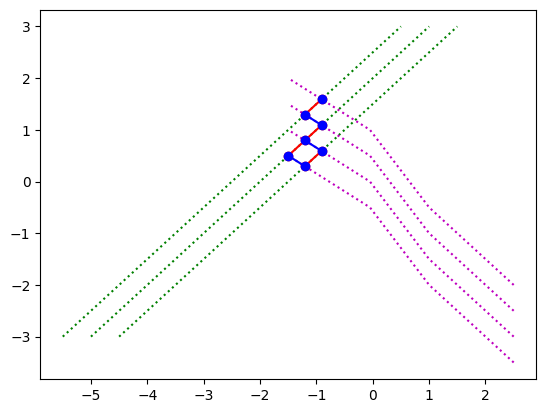

In [ ]:

from fontTools.misc.bezierTools import epsilon
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
%matplotlib inline

def intersection_point(line_1, line_2):
    """
    Calculate the intersection point of two lines defined by multiple points each.
    """

    # finding the closest index
    matrix = line_1[:, None] - line_2[None, :]
    dist_squared_matrix = np.sum(np.power(matrix, 2), axis=2)
    indices = np.unravel_index(
        np.argmin(dist_squared_matrix), dist_squared_matrix.shape
    )

    # indices search range
    mins = np.array([
        [0, indices[0] - 1], 
        [0, indices[1] - 1]
        ]).max(axis=1)
    maxs = np.array([
        [indices[0] + 1, line_1.shape[0] - 1], 
        [indices[1] + 1, line_2.shape[0] - 1]]
        ).min(axis=1)
    i = np.arange(mins[0], maxs[0])
    j = np.arange(mins[1], maxs[1])

    # parametrise the line segment with range 0 to 1
    x1, y1 = line_1[np.ix_(i, [0])], line_1[np.ix_(i, [1])]
    x2, y2 = line_1[np.ix_(i + 1, [0])], line_1[np.ix_(i + 1, [1])]
    x3, y3 = line_2[np.ix_(j, [0])].T, line_2[np.ix_(j, [1])].T
    x4, y4 = line_2[np.ix_(j + 1, [0])].T, line_2[np.ix_(j + 1, [1])].T
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    denom += np.finfo(float).eps  # to avoid division by zero
    t1 = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    t2 = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

    # check the parameter range to verify if the point is with the segment
    mask = np.logical_and.reduce((t1 >= 0.0, t1 <= 1.0, t2 >= 0.0, t2 <= 1.0))
    
    # return intersection point and lines indices
    try: 
        assert np.sum(mask) == 1 # Verify a single intersection
        index = np.argwhere(mask).T
        return \
            np.c_[
                    x1[np.ix_(*index)] + t1[*index] * (x2[np.ix_(*index)] - x1[np.ix_(*index)]),                
                    y1[np.ix_(*index)] + t1[*index] * (y2[np.ix_(*index)] - y1[np.ix_(*index)])
            ].squeeze().astype(np.float32), \
            np.array([i[index[0]], j[index[1]]])
    except:
        return np.array([np.nan, np.nan]), np.array([np.nan, np.nan])
    

def normals_2D(points):
    """
    Calculate the average normal vector at a point on a curve.

    Parameters:
        points (numpy.ndarray): Array of shape (n, 2)

    Returns:
        numpy.ndarray: Unit normal vector at the point
    """
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError(
            f"Input points must be of shape (n, 2). Received {points.shape}"
        )

    normals = np.empty(points.shape)

    edges = np.diff(points, axis=0) 
    # perpendicular vectors
    normals[0] = (-edges[0, 1], edges[0, 0]) # forward difference
    normals[1:-1,:] = np.column_stack(( # central difference
        - np.c_[edges[:-1, 1],edges[1:, 1]].mean(axis=1), 
        + np.c_[edges[:-1, 0],edges[1:, 0]].mean(axis=1),
    ))  
    normals[-1] = (-edges[-1, 1], edges[-1, 0]) # backward difference
    # normalising vector
    magnitudes = np.linalg.norm(normals, axis=1)
    normals = normals / magnitudes[:, np.newaxis]  

    return normals


def indexed_function_caller(func, num, *args):
    """
    Wrapper function to unpack arguments for multiprocessing.
    """
    if not callable(func):
        raise ValueError("func must be a callable function")

    return np.array((*args[:num], func(*args[num:])), dtype=object)

A=np.array([[-3,-3],[-2,-2], [-1, -1], [0,0], [1,1], [2,2], [3,3]], dtype=np.float32)
B=np.array([[2.5,-2], [1.5, -1], [1,-0.5], [-0.05,1], [-1.5,2]], dtype=np.float32)

# result = intersection_point(A, B)
# print(result)


As = np.array(list((A-i*np.array([0.5,0]) for i in range(3,6))), dtype=object)
Bs = np.array(list((B-j*np.array([0,0.5]) for j in range(4))), dtype=object)

for A in As: 
    plt.plot(A[:,0], A[:,1], ':g')
for B in Bs: 
    plt.plot(B[:,0], B[:,1], ':m')

# parallel run

iAs, jBs = np.meshgrid(np.arange(As.shape[0]), np.arange(Bs.shape[0]), indexing='ij')

iargs = np.stack((iAs, jBs), axis=2, dtype=object).reshape(-1,2)
args = list(map(lambda x: (As[x[0]], Bs[x[1]]), iargs))

with ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda ab: intersection_point(*ab), args))

idx = np.arange(As.shape[0]*Bs.shape[0]).reshape(As.shape[0], Bs.shape[0])

nAs = []
for i in range(As.shape[0]):
    line = np.array([results[k][0] for k in idx[i,:]], dtype=np.float32) # Get all results for the current line
    line = line[~np.all(np.isnan(line), axis=1), :] # Remove rows where all elements are NaN
    if line.shape[0] > 0:
        nAs.append(line)

nBs = []
for j in range(Bs.shape[0]):
    line = np.array([results[k][0] for k in idx[:, j]], dtype=np.float32) # Get all results for the current column
    line = line[~np.all(np.isnan(line), axis=1), :] # Remove rows where all elements are NaN
    if line.shape[0] > 0:
        nBs.append(line)

for A in nAs:
    plt.plot(A[:,0], A[:,1], 'o-r')
for B in nBs: 
    plt.plot(B[:,0], B[:,1], 'o-b')




        


# point, indices = intersection_point(A, B)
# print(point, indices)
# plt.plot(point[0], point[1], 'xr')
# plt.scatter(A[indices[0],0], A[indices[0],1], s=100, c='k')
# plt.scatter(B[indices[1],0], B[indices[1],1], s=100, c='k')

# C = normals_2D(A) * 0.5
# plt.quiver(A[:,0], A[:,1], C[:,0], C[:,1], angles='xy', scale_units='xy', scale=1, color='r')


